In [2]:
# Find unique number of classes
def get_classes(files):

    classes=set()
    for input_file in files:
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        classes.add(c.strip())

    return sorted(classes)



# Find unique true labels
def get_true_labels(input_file,classes):

    classes_label = classes
    single_recording_labels=np.zeros(len(classes),dtype=int)


    with open(input_file,'r') as f:
        first_line = f.readline()
        recording_label=first_line.split(' ')[0]
        print(recording_label)
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                for c in tmp:
                    idx = classes.index(c.strip())
                    single_recording_labels[idx]=1

    return recording_label,classes_label,single_recording_labels






def compute_beta_score(labels, output, beta, num_classes, check_errors=True):

    # Check inputs for errors.
    if check_errors:
        if len(output) != len(labels):
            raise Exception('Numbers of outputs and labels must be the same.')

    # Populate contingency table.
    num_recordings = len(labels)

    fbeta_l = np.zeros(num_classes)
    gbeta_l = np.zeros(num_classes)
    fmeasure_l = np.zeros(num_classes)
    accuracy_l = np.zeros(num_classes)

    f_beta = 0
    g_beta = 0
    f_measure = 0
    accuracy = 0

    # Weight function
    C_l=np.ones(num_classes);

    for j in range(num_classes):
        tp = 0
        fp = 0
        fn = 0
        tn = 0

        for i in range(num_recordings):
            
            num_labels = np.sum(labels[i])
        
            if labels[i][j] and output[i][j]:
                tp += 1/num_labels
            elif not labels[i][j] and output[i][j]:
                fp += 1/num_labels
            elif labels[i][j] and not output[i][j]:
                fn += 1/num_labels
            elif not labels[i][j] and not output[i][j]:
                tn += 1/num_labels

        # Summarize contingency table.
        if ((1+beta**2)*tp + (fn*beta**2) + fp):
            fbeta_l[j] = float((1+beta**2)* tp) / float(((1+beta**2)*tp) + (fn*beta**2) + fp)
        else:
            fbeta_l[j] = 1.0

        if (tp + fp + beta * fn):
            gbeta_l[j] = float(tp) / float(tp + fp + beta*fn)
        else:
            gbeta_l[j] = 1.0

        if tp + fp + fn + tn:
            accuracy_l[j] = float(tp + tn) / float(tp + fp + fn + tn)
        else:
            accuracy_l[j] = 1.0

        if 2 * tp + fp + fn:
            fmeasure_l[j] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            fmeasure_l[j] = 1.0


    for i in range(num_classes):
        f_beta += fbeta_l[i]*C_l[i]
        g_beta += gbeta_l[i]*C_l[i]
        f_measure += fmeasure_l[i]*C_l[i]
        accuracy += accuracy_l[i]*C_l[i]


    f_beta = float(f_beta)/float(num_classes)
    g_beta = float(g_beta)/float(num_classes)
    f_measure = float(f_measure)/float(num_classes)
    accuracy = float(accuracy)/float(num_classes)


    return accuracy,f_measure,f_beta,g_beta

    


def compute_auc(labels, probabilities, num_classes, check_errors=True):


    # Check inputs for errors.
    if check_errors:
        if len(labels) != len(probabilities):
            raise Exception('Numbers of outputs and labels must be the same.')

    find_NaNs = np.isnan(probabilities);
    probabilities[find_NaNs] = 0;

    auroc_l = np.zeros(num_classes)
    auprc_l = np.zeros(num_classes)

    auroc = 0
    auprc = 0

    # Weight function - this will change
    C_l=np.ones(num_classes);

    # Populate contingency table.
    num_recordings = len(labels)

    for k in range(num_classes):
    

            # Find probabilities thresholds.
        thresholds = np.unique(probabilities[:,k])[::-1]
        if thresholds[0] != 1:
            thresholds = np.insert(thresholds, 0, 1)
        if thresholds[-1] == 0:
            thresholds = thresholds[:-1]

        m = len(thresholds)
    

        # Populate contingency table across probabilities thresholds.
        tp = np.zeros(m)
        fp = np.zeros(m)
        fn = np.zeros(m)
        tn = np.zeros(m)

        # Find indices that sort the predicted probabilities from largest to
        # smallest.
        idx = np.argsort(probabilities[:,k])[::-1]

        i = 0
        for j in range(m):
            # Initialize contingency table for j-th probabilities threshold.
            if j == 0:
                tp[j] = 0
                fp[j] = 0
                fn[j] = np.sum(labels[:,k])
                tn[j] = num_recordings - fn[j]
            else:
                tp[j] = tp[j - 1]
                fp[j] = fp[j - 1]
                fn[j] = fn[j - 1]
                tn[j] = tn[j - 1]
            # Update contingency table for i-th largest predicted probability.
            while i < num_recordings and probabilities[idx[i],k] >= thresholds[j]:
                if labels[idx[i],k]:
                    tp[j] += 1
                    fn[j] -= 1
                else:
                    fp[j] += 1
                    tn[j] -= 1
                i += 1

        # Summarize contingency table.
        tpr = np.zeros(m)
        tnr = np.zeros(m)
        ppv = np.zeros(m)
        npv = np.zeros(m)


        for j in range(m):
            if tp[j] + fn[j]:
                tpr[j] = float(tp[j]) / float(tp[j] + fn[j])
            else:
                tpr[j] = 1
            if fp[j] + tn[j]:
                tnr[j] = float(tn[j]) / float(fp[j] + tn[j])
            else:
                tnr[j] = 1
            if tp[j] + fp[j]:
                ppv[j] = float(tp[j]) / float(tp[j] + fp[j])
            else:
                ppv[j] = 1
            if fn[j] + tn[j]:
                npv[j] = float(tn[j]) / float(fn[j] + tn[j])
            else:
                npv[j] = 1

        # Compute AUROC as the area under a piecewise linear function with TPR /
        # sensitivity (x-axis) and TNR / specificity (y-axis) and AUPRC as the area
        # under a piecewise constant with TPR / recall (x-axis) and PPV / precision
        # (y-axis).

        for j in range(m-1):
            auroc_l[k] += 0.5 * (tpr[j + 1] - tpr[j]) * (tnr[j + 1] + tnr[j])
            auprc_l[k] += (tpr[j + 1] - tpr[j]) * ppv[j + 1]


    for i in range(num_classes):
        auroc += auroc_l[i]*C_l[i]
        auprc += auprc_l[i]*C_l[i]

    auroc = float(auroc)/float(num_classes)
    auprc = float(auprc)/float(num_classes)

    
    return auroc, auprc


In [1]:
import numpy as np, os, os.path, sys
from scipy import optimize

In [3]:
def evaluate_12ECG_io(label_directory, output_directory):

    # Set parameters.
    label_header       = '12ECGLabel'
    output_label_header  = 'OutputLabel'
    output_probability_header = 'OutputProbability'

    beta = 2
    labels=[]
    output_probabilities=[]

    # Find label and output files.
    label_files = []
    for f in os.listdir(label_directory):
        g = os.path.join(label_directory, f)
        if os.path.isfile(g) and not f.lower().startswith('.') and f.lower().endswith('hea'):
            label_files.append(g)
    label_files = sorted(label_files)

    output_files = []
    for f in os.listdir(output_directory):
        g = os.path.join(output_directory, f)
        if os.path.isfile(g) and not f.lower().startswith('.') and f.lower().endswith('csv'):
            output_files.append(g)
    output_files = sorted(output_files)

    if len(label_files) != len(output_files):
        raise Exception('Numbers of label and output files must be the same.')

    classes = get_classes(label_files)


    # Load labels and outputs.
    num_files = len(label_files)

    for k in range(num_files):

        recording_label,classes_label,single_recording_labels=get_true_labels(label_files[k],classes)
        
        with open(output_files[k],'r') as f:
            tmp_data = f.readlines()
        recording_output = tmp_data[0]
        classes_output = tmp_data[1].split(',')
        single_recording_output = np.array(tmp_data[2].split(','),np.int)
        single_probabilities_output = np.array(tmp_data[3].split(','),np.float64)

       # Check labels and output for errors.

        if not (len(classes_label) == len(classes_output)):
            raise Exception('Numbers of classes for a file must be the same.')
        
        if not (len(single_recording_labels) == len(single_recording_output) == len(single_probabilities_output)):
            raise Exception('Numbers of labels and output for a file must be the same.')

        labels.append(single_recording_labels)
        output_probabilities.append(single_probabilities_output)

    labels=np.array(labels)
    output_probabilities=np.array(output_probabilities)

    num_classes = len(classes_label)
    
    return labels, output_probabilities



In [4]:
labels , output_prob = evaluate_12ECG_io("./input_directory/","./output_directory/")

A0001
A0002
A0003
A0004
A0005
A0006
A0007
A0008
A0009
A0010
A0011
A0012
A0013
A0014
A0015
A0016
A0017
A0018
A0019
A0020
A0021
A0022
A0023
A0024
A0025
A0026
A0027
A0028
A0029
A0030
A0031
A0032
A0033
A0034
A0035
A0036
A0037
A0038
A0039
A0040
A0041
A0042
A0043
A0044
A0045
A0046
A0047
A0048
A0049
A0050
A0051
A0052
A0053
A0054
A0055
A0056
A0057
A0058
A0059
A0060
A0061
A0062
A0063
A0064
A0065
A0066
A0067
A0068
A0069
A0070
A0071
A0072
A0073
A0074
A0075
A0076
A0077
A0078
A0079
A0080
A0081
A0082
A0083
A0084
A0085
A0086
A0087
A0088
A0089
A0090
A0091
A0092
A0093
A0094
A0095
A0096
A0097
A0098
A0099
A0100


In [36]:
threshold = np.linspace(0,1,101)

In [37]:
range(len(threshold))

range(0, 101)

In [38]:
output_prob[1]

array([0.15484753, 0.2601188 , 0.02883521, 0.7054356 , 0.1303635 ,
       0.11415774, 0.2966405 , 0.17011896, 0.03175708])

In [42]:
output_prob.shape

(100, 9)

In [43]:
beta = 2
num_classes = 9
scoring_values=[]
for i in range(len(threshold)):
    output = np.empty(shape=output_prob.shape) 
    for j in range(output_prob.shape[0]):
        for k in range(output_prob.shape[1]):
            if output_prob[j][k] > threshold[i]:
                output[j][k] = 1
            else:
                output[j][k] = 0
            
    accuracy,f_measure,Fbeta_measure,Gbeta_measure = compute_beta_score(labels, output, beta, num_classes)
    auroc,auprc = compute_auc(labels, output_prob,num_classes)
    geomean = (Fbeta_measure + Gbeta_measure)/2
    print("--------------------------------------")
    print("Threshold = {:0.2f}".format(threshold[i]))
    print("AUROC|AUPRC|Accuracy|F measure|F2|G2")
    print(auroc,auprc,accuracy,f_measure,Fbeta_measure,Gbeta_measure)
    print("overall score:")
    print(geomean)
    print("--------------------------------------")
    scoring_values.append(geomean)
    
        


--------------------------------------
Threshold = 0.00
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.1122334455667789 0.19824208774687738 0.37090041408248703 0.1122334455667789
overall score:
0.24156692982463296
--------------------------------------
--------------------------------------
Threshold = 0.01
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.11447811447811447 0.1985706220011324 0.3714330626336602 0.11242813623766004
overall score:
0.24193059943566014
--------------------------------------
--------------------------------------
Threshold = 0.02
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.13524130190796857 0.20188783618554806 0.37673616326409726 0.11440679294496799
overall score:
0.24557147810453261
--------------------------------------
--------------------------------------
Threshold = 0.03
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.1868686868686868

--------------------------------------
Threshold = 0.30
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.861952861952862 0.6568788576765163 0.7757921953548216 0.49342664416193827
overall score:
0.6346094197583799
--------------------------------------
--------------------------------------
Threshold = 0.31
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.8742985409652078 0.6787206596882641 0.7889456396278693 0.5138063128625026
overall score:
0.651375976245186
--------------------------------------
--------------------------------------
Threshold = 0.32
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.8821548821548822 0.692788293768686 0.7991999851055702 0.5281164271156101
overall score:
0.6636582061105902
--------------------------------------
--------------------------------------
Threshold = 0.33
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.8945005611672278 0.6896669242

--------------------------------------
Threshold = 0.63
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.9640852974186305 0.7118885952151672 0.6868103759564312 0.5597907424532811
overall score:
0.6233005592048562
--------------------------------------
--------------------------------------
Threshold = 0.64
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.9618406285072951 0.7022057097152882 0.6732082008998955 0.5392697429849131
overall score:
0.6062389719424044
--------------------------------------
--------------------------------------
Threshold = 0.65
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.9607182940516275 0.6973908949004735 0.6660432979016592 0.5255131292282995
overall score:
0.5957782135649794
--------------------------------------
--------------------------------------
Threshold = 0.66
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.9618406285072951 0.70087300

--------------------------------------
Threshold = 0.99
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.8877665544332211 0.0 0.0 0.0
overall score:
0.0
--------------------------------------
--------------------------------------
Threshold = 1.00
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9862823661855289 0.8893292993491486 0.8877665544332211 0.0 0.0 0.0
overall score:
0.0
--------------------------------------


In [44]:
import matplotlib.pyplot as plt

In [45]:
scoring_values = np.array(scoring_values)

In [46]:
scoring_values.max()

0.7091738436097179

In [47]:
threshold[maxpoint]

array([0.4])

In [48]:
maxpoint=np.where(scoring_values ==scoring_values.max())

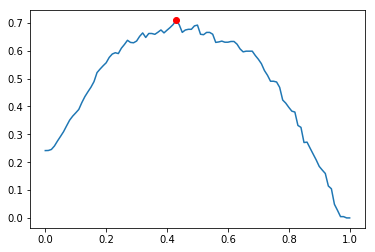

In [49]:
plt.plot(threshold,scoring_values)
plt.plot(threshold[maxpoint], scoring_values[maxpoint], 'ro')

In [5]:
def thr_to_accuracy(thr, Y_test, predictions):
    return -accuracy_score(Y_test, np.array(predictions>thr, dtype=np.int))



In [7]:
best_thr = optimize.fmin(thr_to_accuracy, args=(labels, output_prob), x0=0.5)

NameError: name 'accuracy_score' is not defined

In [9]:
h = np.array([[0.2,0.2],[0.3,0.3]])

In [10]:
f = np.array([[0.2,0.3],[0.2,0.3]])

In [12]:
g = f==h

In [14]:
g = g*1

In [15]:
g

array([[1, 0],
       [0, 1]])

In [35]:
def compute_score(labels, output_prob, thresholds):
    #check_errors=True
    
    beta = 2
    num_classes = 9
    # Check inputs for errors.
    #if check_errors:
        #if len(probabilities) != len(labels):
            #raise Exception('Numbers of outputs and labels must be the same.')

    # Populate contingency table.
    num_recordings = len(labels)

    fbeta_l = np.zeros(num_classes)
    gbeta_l = np.zeros(num_classes)
    fmeasure_l = np.zeros(num_classes)
    accuracy_l = np.zeros(num_classes)

    f_beta = 0
    g_beta = 0
    f_measure = 0
    accuracy = 0
    
    output = output_prob > thresholds
    output = output * 1

    # Weight function
    C_l=np.ones(num_classes);

    for j in range(num_classes):
        tp = 0
        fp = 0
        fn = 0
        tn = 0

        for i in range(num_recordings):
            
            num_labels = np.sum(labels[i])
        
            if labels[i][j] and output[i][j]:
                tp += 1/num_labels
            elif not labels[i][j] and output[i][j]:
                fp += 1/num_labels
            elif labels[i][j] and not output[i][j]:
                fn += 1/num_labels
            elif not labels[i][j] and not output[i][j]:
                tn += 1/num_labels

        # Summarize contingency table.
        if ((1+beta**2)*tp + (fn*beta**2) + fp):
            fbeta_l[j] = float((1+beta**2)* tp) / float(((1+beta**2)*tp) + (fn*beta**2) + fp)
        else:
            fbeta_l[j] = 1.0

        if (tp + fp + beta * fn):
            gbeta_l[j] = float(tp) / float(tp + fp + beta*fn)
        else:
            gbeta_l[j] = 1.0

        if tp + fp + fn + tn:
            accuracy_l[j] = float(tp + tn) / float(tp + fp + fn + tn)
        else:
            accuracy_l[j] = 1.0

        if 2 * tp + fp + fn:
            fmeasure_l[j] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            fmeasure_l[j] = 1.0


    for i in range(num_classes):
        f_beta += fbeta_l[i]*C_l[i]
        g_beta += gbeta_l[i]*C_l[i]
        f_measure += fmeasure_l[i]*C_l[i]
        accuracy += accuracy_l[i]*C_l[i]


    f_beta = float(f_beta)/float(num_classes)
    g_beta = float(g_beta)/float(num_classes)
    f_measure = float(f_measure)/float(num_classes)
    accuracy = float(accuracy)/float(num_classes)

    #return accuracy,f_measure,f_beta,g_beta
    return f_beta

In [49]:
def compute_score_f2(labels, output):
    
    beta = 2
    num_classes = 9
    # Populate contingency table.
    num_recordings = len(labels)

    fbeta_l = np.zeros(num_classes)
    gbeta_l = np.zeros(num_classes)
    fmeasure_l = np.zeros(num_classes)
    accuracy_l = np.zeros(num_classes)

    f_beta = 0
    g_beta = 0
    f_measure = 0
    accuracy = 0

    # Weight function
    C_l=np.ones(num_classes);

    for j in range(num_classes):
        tp = 0
        fp = 0
        fn = 0
        tn = 0

        for i in range(num_recordings):
            
            num_labels = np.sum(labels[i])
        
            if labels[i][j] and output[i][j]:
                tp += 1/num_labels
            elif not labels[i][j] and output[i][j]:
                fp += 1/num_labels
            elif labels[i][j] and not output[i][j]:
                fn += 1/num_labels
            elif not labels[i][j] and not output[i][j]:
                tn += 1/num_labels

        # Summarize contingency table.
        if ((1+beta**2)*tp + (fn*beta**2) + fp):
            fbeta_l[j] = float((1+beta**2)* tp) / float(((1+beta**2)*tp) + (fn*beta**2) + fp)
        else:
            fbeta_l[j] = 1.0

        if (tp + fp + beta * fn):
            gbeta_l[j] = float(tp) / float(tp + fp + beta*fn)
        else:
            gbeta_l[j] = 1.0

        if tp + fp + fn + tn:
            accuracy_l[j] = float(tp + tn) / float(tp + fp + fn + tn)
        else:
            accuracy_l[j] = 1.0

        if 2 * tp + fp + fn:
            fmeasure_l[j] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            fmeasure_l[j] = 1.0


    for i in range(num_classes):
        f_beta += fbeta_l[i]*C_l[i]
        g_beta += gbeta_l[i]*C_l[i]
        f_measure += fmeasure_l[i]*C_l[i]
        accuracy += accuracy_l[i]*C_l[i]


    f_beta = float(f_beta)/float(num_classes)
    g_beta = float(g_beta)/float(num_classes)
    f_measure = float(f_measure)/float(num_classes)
    accuracy = float(accuracy)/float(num_classes)


    return f_beta


In [55]:
def compute_score_g2(labels, output):
    
    beta = 2
    num_classes = 9
    # Populate contingency table.
    num_recordings = len(labels)

    fbeta_l = np.zeros(num_classes)
    gbeta_l = np.zeros(num_classes)
    fmeasure_l = np.zeros(num_classes)
    accuracy_l = np.zeros(num_classes)

    f_beta = 0
    g_beta = 0
    f_measure = 0
    accuracy = 0

    # Weight function
    C_l=np.ones(num_classes);

    for j in range(num_classes):
        tp = 0
        fp = 0
        fn = 0
        tn = 0

        for i in range(num_recordings):
            
            num_labels = np.sum(labels[i])
        
            if labels[i][j] and output[i][j]:
                tp += 1/num_labels
            elif not labels[i][j] and output[i][j]:
                fp += 1/num_labels
            elif labels[i][j] and not output[i][j]:
                fn += 1/num_labels
            elif not labels[i][j] and not output[i][j]:
                tn += 1/num_labels

        # Summarize contingency table.
        if ((1+beta**2)*tp + (fn*beta**2) + fp):
            fbeta_l[j] = float((1+beta**2)* tp) / float(((1+beta**2)*tp) + (fn*beta**2) + fp)
        else:
            fbeta_l[j] = 1.0

        if (tp + fp + beta * fn):
            gbeta_l[j] = float(tp) / float(tp + fp + beta*fn)
        else:
            gbeta_l[j] = 1.0

        if tp + fp + fn + tn:
            accuracy_l[j] = float(tp + tn) / float(tp + fp + fn + tn)
        else:
            accuracy_l[j] = 1.0

        if 2 * tp + fp + fn:
            fmeasure_l[j] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            fmeasure_l[j] = 1.0


    for i in range(num_classes):
        f_beta += fbeta_l[i]*C_l[i]
        g_beta += gbeta_l[i]*C_l[i]
        f_measure += fmeasure_l[i]*C_l[i]
        accuracy += accuracy_l[i]*C_l[i]


    f_beta = float(f_beta)/float(num_classes)
    g_beta = float(g_beta)/float(num_classes)
    f_measure = float(f_measure)/float(num_classes)
    accuracy = float(accuracy)/float(num_classes)


    return g_beta


In [53]:
def thr_to_accuracy_f2(thr, labels, output_prob):
    return -compute_score_f2(labels, np.array(output_prob>thr, dtype=np.int))

In [57]:
best_thr_f2 = optimize.fmin(thr_to_accuracy_f2, args=(labels, output_prob), x0=[0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4])

Optimization terminated successfully.
         Current function value: -0.820436
         Iterations: 54
         Function evaluations: 165


In [58]:
best_thr_f2

array([0.39778453, 0.43691281, 0.39572007, 0.42374531, 0.33969824,
       0.3764101 , 0.44612838, 0.38569005, 0.41601847])

In [59]:
def thr_to_accuracy_g2(thr, labels, output_prob):
    return -compute_score_g2(labels, np.array(output_prob>thr, dtype=np.int))

In [62]:
best_thr_g2 = optimize.fmin(thr_to_accuracy_g2, args=(labels, output_prob), x0=[0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4])

Optimization terminated successfully.
         Current function value: -0.639452
         Iterations: 56
         Function evaluations: 178


In [63]:
best_thr_g2

array([0.40303395, 0.42757274, 0.39164851, 0.42428864, 0.32466381,
       0.37414041, 0.43171492, 0.42716966, 0.41996487])